# Introduction

This is a notebook that use the GitHub status to find the oldest PR commit which has a status that contains a linkt to travis-ci.org. We compare this date against the date returned by the Travis API, and conclude that the status date is more accurate.  

In [15]:
from pymongo import MongoClient

mongo_client = MongoClient()

database = mongo_client["graduation"]

pull_requests_collection = database["pull_requests"]

projects_collection = database["projects"]

commits_collection = database["commits"]


In [18]:
from urllib.parse import urlparse
import analysis_utilities

import datetime

scraped_projects = list(projects_collection.find({'succeeded': True, 'status_travis_date': {'$exists':False}}))
print("Analyzing {}".format(len(scraped_projects)))

for project in scraped_projects:
    print("-----------------------------------------")
    print("Starting {}".format(project["full_name"]))
    
    pull_requests = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],
                                                       'project_owner': project["full_name"].split("/")[0]}))
    
    sha_list = list([commit for pr in pull_requests for commit in pr["commits"]])
        
    commits = [commits_collection.find_one({'sha': sha_hash}) for sha_hash in sha_list]
    
    statuses = list([status for commit in commits for status in commit["statuses"]])
    
    print("{} commits, and {} statuses".format(len(commits), len(statuses)))
    
    print("Oldest reported status is: {}".format(min([status["created_at"] for status in statuses])))
    
    all_urls = [status["target_url"] for status in statuses]
    
    hostnames = list(set([urlparse(url).hostname for url in all_urls if urlparse(url).hostname is not None]))
    
    print("Total of {} unique hostnames".format(len(hostnames)))
    
    print("Hostnames are: {}".format(", ".join(hostnames)))
    
    oldest_travis_date = min([status["created_at"] for status in statuses if urlparse(status["target_url"]).hostname == "travis-ci.org"])
    
    oldest_status_date = min([status["created_at"] for status in statuses])
    
    print("Oldest travis status is: {}, versus the travis reported date: {}. While oldest status date is {}".format(oldest_travis_date, project["first_build_date_travis"], oldest_status_date))
    
    if not (oldest_travis_date - oldest_status_date).days > 15:
        project["status_travis_date"] = oldest_travis_date
        
        prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, pull_requests)
    
        print("{} prs before, and {} prs after".format(len(prs_before), len(prs_after))) 
    else:
        project.pop("status_travis_date", None)
        
  
    
    projects_collection.replace_one({"full_name" : project["full_name"]}, project)
    

Analyzing 15
-----------------------------------------
Starting RIOT-OS/RIOT
21815 commits, and 65464 statuses
Oldest reported status is: 2014-02-20 07:56:43
Total of 6 unique hostnames
Hostnames are: ci.riot-os.org, travis-ci.org, app.codacy.com, stedten.imp.fu-berlin.de, ci.riot-labs.de, riot-ci.inet.haw-hamburg.de
Oldest travis status is: 2014-04-28 22:05:23, versus the travis reported date: 2017-11-13 13:30:05. While oldest status date is 2014-02-20 07:56:43
-----------------------------------------
Starting ReactiveCocoa/ReactiveCocoa
12140 commits, and 23800 statuses
Oldest reported status is: 2012-08-29 00:37:47
Total of 3 unique hostnames
Hostnames are: janky.rs.github.com, travis-ci.org, janky.githubapp.com
Oldest travis status is: 2015-01-05 19:22:55, versus the travis reported date: 2016-07-18 12:38:30. While oldest status date is 2012-08-29 00:37:47
-----------------------------------------
Starting NLog/NLog
4848 commits, and 28084 statuses
Oldest reported status is: 2014-

In [34]:
def do_before_after_boxplot(before_data, after_data, names, title, ylabel, yscale="log"):
    plt.figure(figsize=(15,5))


    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)   

    bpl = plt.boxplot(before_data, positions=np.array(range(len(before_data)))*2.0-0.4, sym='o', widths=0.6)
    bpr = plt.boxplot(after_data, positions=np.array(range(len(after_data)))*2.0+0.4, sym='o', widths=0.6)
    set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, '#2C7BB6')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label='Before CI')
    plt.plot([], c='#2C7BB6', label='After CI')
    plt.legend()

    plt.xticks(range(0, len(names) * 2, 2), names, rotation="vertical")
    plt.xlim(-2, len(names)*2)

    plt.yscale(yscale)

    plt.title(title)
    plt.ylabel(ylabel)

    plt.show()

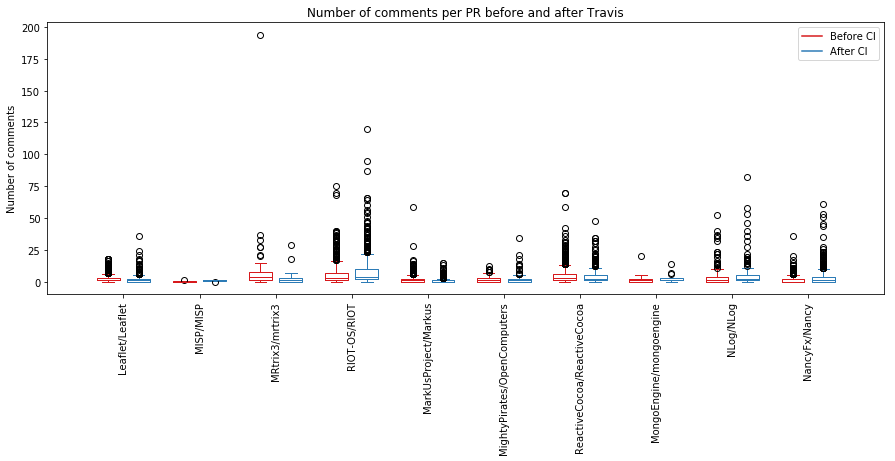

In [35]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

%matplotlib inline
plt.rcParams['savefig.dpi'] = 100 

before_total_comments = []
after_total_comments = []

project_names = []

for project in scraped_projects[:10]:
    
    project_names.append(project["full_name"])
    
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True)
    
    before_total_comments.append([len(pr["raw_comments"]) for pr in prs_before])
    after_total_comments.append([len(pr["raw_comments"]) for pr in prs_after])

do_before_after_boxplot(before_total_comments, after_total_comments, project_names, 
                       'Number of comments per PR before and after Travis',
                       'Number of comments',
                       yscale='linear')
    


In [36]:
def calculate_time_to_first_comment(prs):
    for pr in prs:
        
        first_comment_time = None
        
        for cmmnt in pr["raw_comments"]:
            cmmnt["is_first_human"] = False
            if cmmnt["user"]["login"]  not in ["coveralls", "codecov-io", "slnode", "pep8speaks", "rh-atomic-bot", "cesium-concierge"] and first_comment_time is None:
                first_comment_time = cmmnt["created_at"]
                cmmnt["is_first_human"] = True
        
        if first_comment_time == None:
            pr["minutes_till_first_comment"] = first_comment_time
            continue
                
        
        pr["minutes_till_first_comment"] = (first_comment_time - pr["created_at"]).total_seconds() / 60.0

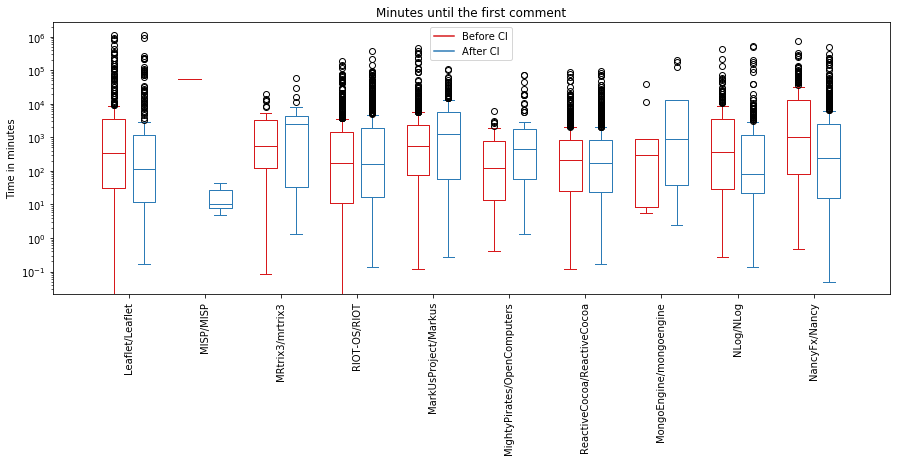

In [37]:
before_time_to_first_comment = []
after_time_to_first_comment = []

project_names = []

for project in scraped_projects[:10]:
    
    project_names.append(project["full_name"])
    
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, True)
    
    calculate_time_to_first_comment(prs_before)
    calculate_time_to_first_comment(prs_after)
    
    before_time_to_first_comment.append([pr["minutes_till_first_comment"] for pr in prs_before if pr["minutes_till_first_comment"] is not None])
    after_time_to_first_comment.append([pr["minutes_till_first_comment"] for pr in prs_after if pr["minutes_till_first_comment"] is not None])

do_before_after_boxplot(before_time_to_first_comment, after_time_to_first_comment, project_names, 
                       'Minutes until the first comment',
                       'Time in minutes')